# Multisession registration with CaImAn

This notebook will help to demonstrate how to use CaImAn on movies recorded in multiple sessions. CaImAn has in-built functions that align movies from two or more sessions and try to recognize components that are imaged in some or all of these recordings.

The basic function for this is `caiman.base.rois.register_ROIs()`. It takes two sets of spatial components and finds components present in both using an intersection over union metric and the Hungarian algorithm for optimal matching.
`caiman.base.rois.register_multisession()` takes a list of spatial components, aligns sessions 1 and 2, keeps the union of the matched and unmatched components to register it with session 3 and so on.

In [88]:
from IPython import get_ipython
from matplotlib import pyplot as plt
import numpy as np
import pickle
import h5py
import glob
import pims_nd2
import pandas as pd
from collections import OrderedDict

from caiman.base.rois import register_multisession
from caiman.utils import visualization
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.utils.utils import download_demo

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


loading the files and trying to make everything automatic

In [36]:
animal='OPI2356'
conditions=['baseline_d1','baseline_d2','24hrs_post_SD']

In [38]:
# Load multisession data (spatial components and mean intensity templates) (should be replaced by actual data)
home_folder=f'D:/sd_project_pbox/exported_data/{animal}/'
raw_data_folder=f'D:/sd_project_pbox/raw_data/{animal}'
output_folder=f'D:/sd_project_pbox/results/{animal}/'

files_list=[]
templates_list=[]
cnmf_list=[]
spatials=[]
dims=[]
# spatials=[cnmf_1.estimates.A,cnmf_2.estimates.A,cnmf_3.estimates.A]
# dims=cnmf_1.dims

for condition in conditions:

    #finding file paths
    fpath= glob.glob(f"{home_folder}/{condition}/*.hdf5")[0]
    files_list.append(fpath)

    #sstoring cnfs
    cnmf_ind=cnmf.load_CNMF(fpath,'r')
    cnmf_list.append(cnmf_ind)
    #sotring spatial components
    spatial=cnmf_ind.estimates.A
    spatials.append(spatial)
    #storing dims
    dim=cnmf_ind.dims
    dims.append(dim)

    #template paths
    template_path=glob.glob(f"{raw_data_folder}/*{condition}/*.nd2")[0]
    nikon_movie=pims_nd2.ND2_Reader(template_path)
    template=np.mean(nikon_movie[:600],axis=0)
    templates_list.append(template)


In [242]:
from matplotlib.colors import LinearSegmentedColormap

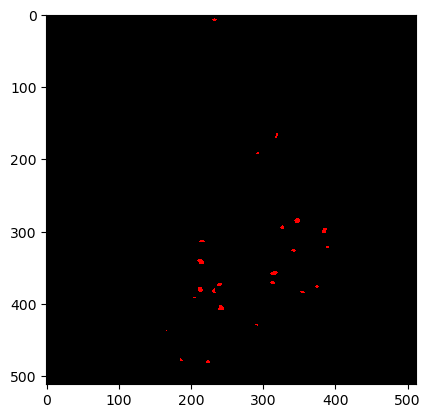

In [251]:
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['black', 'red'], N=2)

plt.imshow(template3,cmap=cmap)

## Use `register_multisession()`

The function `register_multisession()` requires 3 arguments:
- `A`: A list of ndarrays or scipy.sparse.csc matrices with (# pixels X # component ROIs) for each session
- `dims`: Dimensions of the FOV, needed to restore spatial components to a 2D image
- `templates`: List of ndarray matrices of size `dims`, template image of each session

In [39]:
spatial_union, assignments, matchings = register_multisession(A=spatials, dims=dims[0])#, templates=templates)

c:\Users\ttami\anaconda3\envs\caiman\lib\site-packages\scipy\sparse\_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [57]:
# Find the rows where there are no NaN values
#meaning where are the cells in all of the days
cr_reg_cells = assignments[~np.isnan(assignments).any(axis=1)].astype(int)

In [60]:
cr_reg_cells_df=pd.DataFrame(data=cr_reg_cells,columns=conditions)

In [89]:
#find the number of cells that were place in all three conditions
output_file=f"D:/sd_project_pbox/results/{animal}"

#first store the place cells somewhere
pc_cells=OrderedDict()


for condition in conditions:
    pc_cells_per_day=h5py.File(f'{output_file}/{condition}/output_info.h5')['place_cells_tuned_vector']
    pc_cells_per_day=np.array(pc_cells_per_day)
    pc_cells[condition]=[]
    pc_cells[condition].append(pc_cells_per_day)

In [90]:
pc_cells

OrderedDict([('baseline_d1',
              [array([  5,  13,  16,  22,  30,  32,  37,  43,  55,  60,  71,  72,  74,
                       75,  77,  78,  79,  82,  83,  85,  86,  87,  96, 100, 113, 116,
                      118, 121, 127, 132, 136, 140, 146, 162, 168, 172, 180, 183, 189,
                      193, 196, 197, 199, 205, 207, 215, 228, 245, 248, 253, 262, 264,
                      267, 268, 278, 284])]),
             ('baseline_d2',
              [array([  5,   8,   9,  11,  16,  20,  21,  25,  29,  30,  37,  39,  40,
                       41,  47,  49,  52,  54,  69,  75,  79,  83,  89,  94,  95,  99,
                      100, 103, 106, 107, 108, 118, 128, 136, 145, 150, 153, 174, 177,
                      180, 182, 187, 189, 191, 192, 195, 197, 202, 204, 209, 211, 212,
                      214, 220, 223, 231, 233, 248, 254, 255, 256, 257, 258, 259, 261,
                      263, 267, 275, 277, 278])]),
             ('24hrs_post_SD',
              [array([  4,   5,

In [ ]:
#omnipresent cells
omnipresent_pc_cells=cr_reg_cells[np.isin(cr_reg_cells[:,1],pc_day_2) & np.isin(cr_reg_cells[:,2],pc_day_3)]

In [72]:
#identify common place cells in baseline 2 and 24 hrs post SD
df=cr_reg_cells_df
mask = df[(df['baseline_d1'].isin(pc_cells[0])) & (df['baseline_d2'].isin(pc_cells[1])) & (df['24hrs_post_SD'].isin(pc_cells[2]))]


In [111]:
#define cross registered place cells per session

def filter_cross_registered_place_cells(df, sessions, place_cell_arrays):
    if not sessions:
        return df  # Return the original DataFrame if no sessions are specified
    
    mask = df[sessions[0]].isin(place_cell_arrays[sessions[0]][0])
    for session in sessions[1:]:
        mask &= df[session].isin(place_cell_arrays[session][0])
    
    filtered_df = df[mask]
    return filtered_df[sessions]


In [120]:

sessions=conditions #all of them
sessions=['baseline_d1','24hrs_post_SD']

# Example usage for two sessions:
filtered_df = filter_cross_registered_place_cells(df, sessions, pc_cells)
print(f"comparidson between {sessions}")
print(filtered_df)



comparidson between ['baseline_d1', '24hrs_post_SD']
    baseline_d1  24hrs_post_SD
15           79             81
17           82             86
23          116            117
40          196            199


In [152]:
#indetify only the cross registered place cells in each of the recordings
fr_rate_maps_to_compare=OrderedDict()

for session in sessions:
    fr_rate_maps_to_compare[session]=[]

for session in sessions:
    avr_fr_rate_map=h5py.File(f'{output_folder}/{session}/output_info.h5')['avr_firing_rate_maps']
    avr_fr_rate_map=pd.DataFrame(avr_fr_rate_map)
    cr_reg_cells_values=filtered_df[session].values
    avr_fr_rate_map=avr_fr_rate_map.iloc[cr_reg_cells_values]
    fr_rate_maps_to_compare[session]=avr_fr_rate_map

# avr_fir_rate_map_day_2=h5py.File(f'{output_files}/baseline_d2/output_info.h5')['avr_firing_rate_maps']
# avr_fir_rate_map_day_2=pd.DataFrame(avr_fir_rate_map_day_2)
# cr_pc_act_day_2=avr_fir_rate_map_day_2.iloc[list(cr_reg_pl_cells_days_2_3[:,1].astype(int))]

# avr_fir_rate_map_day_3=h5py.File(f'{output_files}/24hrs_post_SD/output_info.h5')['avr_firing_rate_maps']
# avr_fir_rate_map_day_3=pd.DataFrame(avr_fir_rate_map_day_3)
# cr_pc_act_day_3=avr_fir_rate_map_day_3.iloc[list(cr_reg_pl_cells_days_2_3[:,2].astype(int))]

In [156]:
place_cell_activity=fr_rate_maps_to_compare['baseline_d1']

In [157]:
place_cell_indexes_max=np.argmax(place_cell_activity,axis=1) #finding the place of the max activity of every cell
place_cell_indexed_filtered=place_cell_activity.apply(np.argmax, axis=1).sort_values().index #there are the new indexes of the place cells just so thez can form the nice place cell diagram
transpose=place_cell_indexed_filtered
place_cell_activity=place_cell_activity.reindex(index=transpose) #reindexing the place cell panda frame according to the max activitz and the position in the belt

In [159]:
import seaborn as sns

[Text(0, 0, '0'), Text(50, 0, '50'), Text(100, 0, '100'), Text(150, 0, '150')]

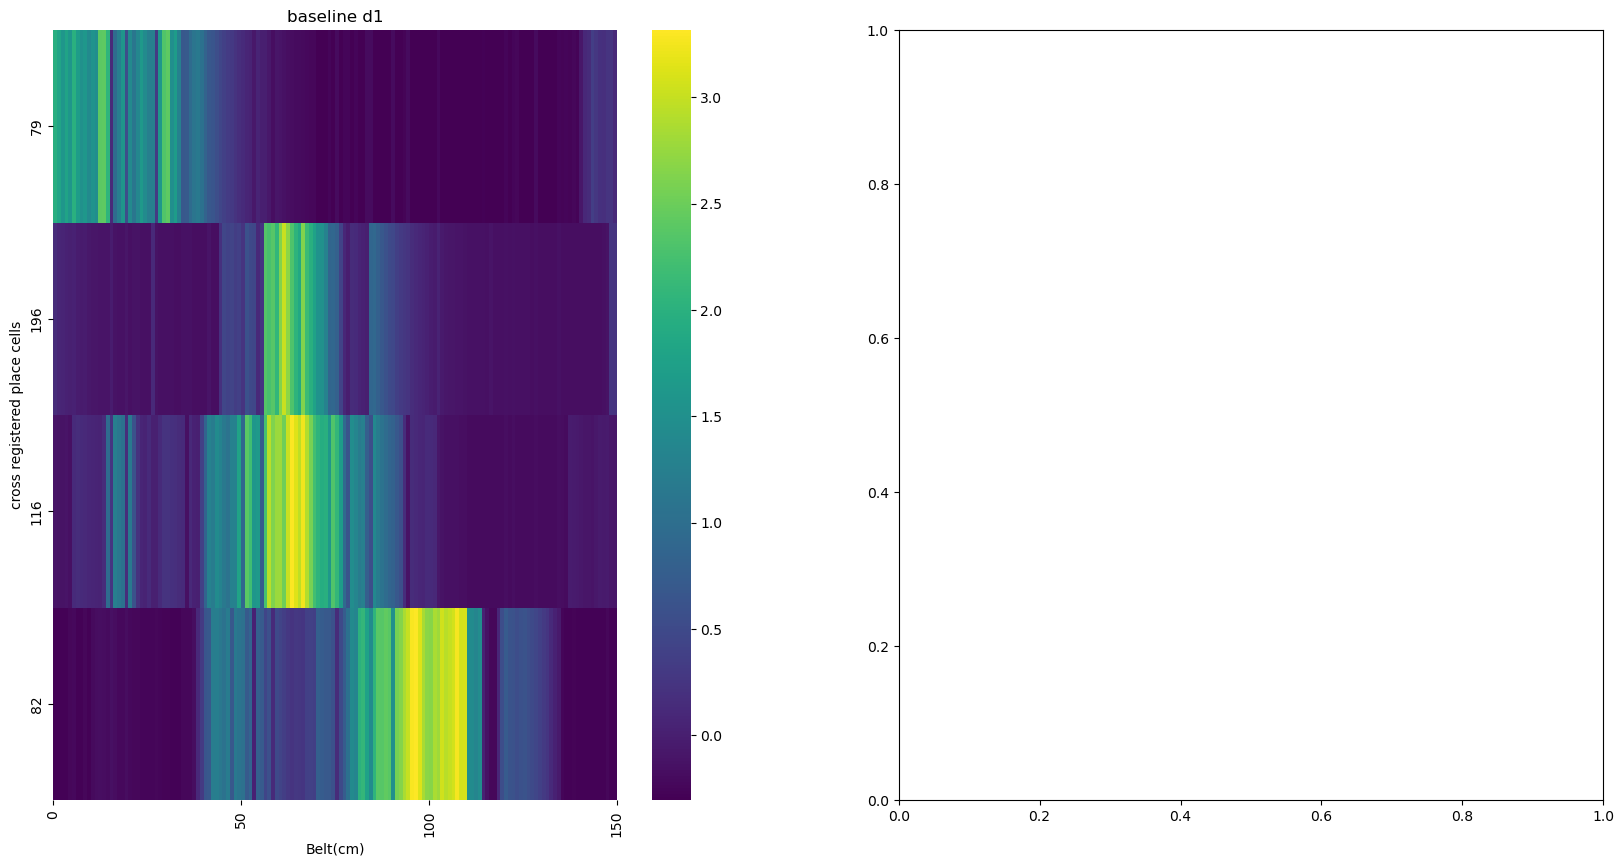

In [170]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
                    
custom_ticks = [0, 50, 100, 150]  # Specify the positions where you want the ticks
custom_labels = ['0', '50', '100', '150']  

sns.heatmap(place_cell_activity,ax=ax[0],cmap='viridis')
ax[0].set_ylabel('cross registered place cells')
ax[0].set_xlabel('Belt(cm)')
ax[0].set_title('baseline d1')
ax[0].set_xticks(custom_ticks)
ax[0].set_xticklabels(custom_labels)

In [221]:
cr_reg_pl_cells_days_2_3

array([[ 25., 209., 215.],
       [ 31.,  30.,  39.],
       [196., 257., 199.]])

In [226]:
place_cell_activity_3

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
102,0.110791,0.086170,-0.046230,-0.094587,-0.083420,-0.107110,-0.096191,-0.096778,-0.108937,-0.086510,...,-0.000804,-0.008777,-0.009404,0.013813,-0.029628,-0.075166,-0.074135,-0.076159,-0.067491,0.106152
105,-0.106384,-0.108427,-0.093335,-0.105852,-0.094091,-0.117614,-0.105852,-0.105852,-0.117614,-0.094091,...,-0.083023,-0.015469,-0.054412,-0.058641,-0.077434,-0.070388,-0.085897,-0.087204,-0.078301,-0.104756
196,0.220900,0.156862,-0.012944,-0.042861,0.036267,-0.038536,0.110673,0.126543,0.009540,-0.009306,...,0.663735,0.719321,0.755260,0.031882,0.126579,-0.032753,0.265442,0.238194,0.215993,0.213035
238,-0.181662,-0.189832,-0.134762,-0.173888,-0.154700,-0.207710,-0.189259,-0.209015,-0.234690,-0.187752,...,-0.096997,0.044708,-0.001639,-0.212580,-0.228713,-0.184945,-0.208943,-0.209122,-0.186034,-0.233351


In [234]:
place_cell_activity_3=cr_pc_act_day_3.reindex(index=new_indices)

In [231]:
new_indices=test[np.argsort(transpose)][:,2].astype(int)

<Axes: >

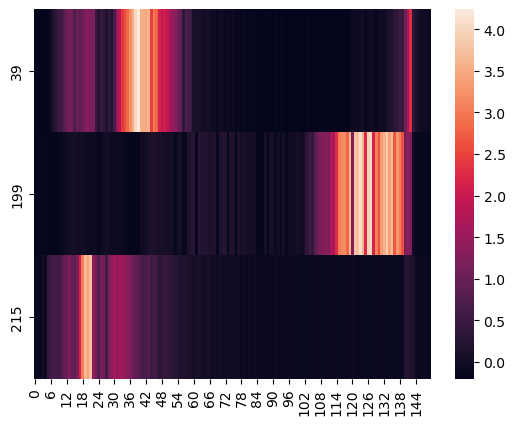

In [235]:
sns.heatmap(place_cell_activity_3)

<Axes: >

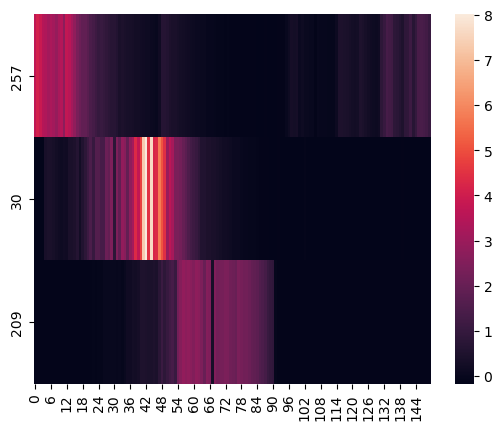

In [213]:
sns.heatmap(place_cell_activity)

In [ ]:
place_cell_activity_3=cr_pc_act_day_3
place_cell_indexes_max=np.argmax(place_cell_activity,axis=1) #finding the place of the max activity of every cell
place_cell_indexed_filtered=place_cell_activity.apply(np.argmax, axis=1).sort_values().index #there are the new indexes of the place cells just so thez can form the nice place cell diagram
original=place_cell_activity.index
transpose=place_cell_indexed_filtered
place_cell_activity_2=place_cell_activity.reindex(index=transpose) #reindexing the place cell panda frame according to the max activitz and the position in the belt

In [165]:
transpose

Index([238, 105, 102, 196], dtype='int64')

In [170]:
new_indices=place_cell_indexed_filtered.get_indexer(common_cells[:,1])

In [177]:
index_pc_day_2=common_cells[:,2][new_indices]

In [179]:
index_pc_day_2=pd.Index(index_pc_day_2)

In [189]:
index_pc_day_2

Index([235.0, 98.0, 64.0, 93.0], dtype='float64')

In [185]:
index_pc_day_2

Index([235.0, 98.0, 64.0, 93.0], dtype='float64')

In [182]:
index_pc_day_2.astype(int)

Index([235, 98, 64, 93], dtype='int32')

In [173]:
new_indices=pd.Index(new_indices)

In [186]:
place_cell_activity_3

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
102,0.110791,0.086170,-0.046230,-0.094587,-0.083420,-0.107110,-0.096191,-0.096778,-0.108937,-0.086510,...,-0.000804,-0.008777,-0.009404,0.013813,-0.029628,-0.075166,-0.074135,-0.076159,-0.067491,0.106152
105,-0.106384,-0.108427,-0.093335,-0.105852,-0.094091,-0.117614,-0.105852,-0.105852,-0.117614,-0.094091,...,-0.083023,-0.015469,-0.054412,-0.058641,-0.077434,-0.070388,-0.085897,-0.087204,-0.078301,-0.104756
196,0.220900,0.156862,-0.012944,-0.042861,0.036267,-0.038536,0.110673,0.126543,0.009540,-0.009306,...,0.663735,0.719321,0.755260,0.031882,0.126579,-0.032753,0.265442,0.238194,0.215993,0.213035
238,-0.181662,-0.189832,-0.134762,-0.173888,-0.154700,-0.207710,-0.189259,-0.209015,-0.234690,-0.187752,...,-0.096997,0.044708,-0.001639,-0.212580,-0.228713,-0.184945,-0.208943,-0.209122,-0.186034,-0.233351


In [175]:
new_indices

Index([2, 1, 3, 0], dtype='int64')

In [188]:
place_cell_activity_3.reindex(index=index_pc_day_2.astype(int))

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

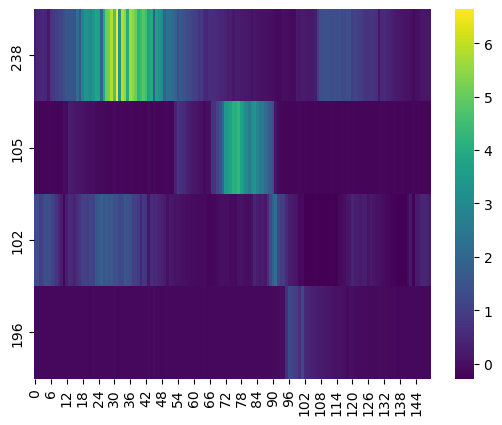

In [149]:
sns.heatmap(place_cell_activity,cmap='viridis')

In [138]:
avr_fir_rate_map_day_2.iloc[2,:]

0     -0.103600
1      0.050562
2      0.277733
3      0.107494
4     -0.212416
         ...   
145    0.189913
146    0.093457
147    0.065574
148    0.047429
149   -0.066386
Name: 2, Length: 150, dtype: float64

In [80]:
cr_pc=np.where

(array([ 22.,  71.,  72.,  77.,  79.,  82., 121., 127., 196., 197., 268.]),
 array([ 22.,  30.,  83.,  85., 116., 180., 183., 193., 196., 207.]))

The function returns 3 variables for further analysis:
- `spatial_union`: csc_matrix (# pixels X # total distinct components), the union of all ROIs across all sessions aligned to the FOV of the last session.
- `assignments`: ndarray (# total distinct components X # sessions). `assignments[i,j]=k` means that component `k` from session `j` has been identified as component `i` from the union of all components, otherwise it takes a `NaN` value. Note that for each `i` there is at least one session index `j` where `assignments[i,j]!=NaN`.
- `matchings`: list of (# sessions) lists. Saves `spatial_union` indices of individual components in each session. `matchings[j][k] = i` means that component `k` from session `j` is represented by component `i` in the union of all components `spatial_union`. In other words `assignments[matchings[j][k], j] = j`.

## Post-alignment screening

The three outputs can be used to filter components in various ways. For example we can find the components that were active in at least a given a number of sessions. For more examples, check [this script](https://github.com/flatironinstitute/CaImAn/blob/master/use_cases/eLife_scripts/figure_9/Figure_9_alignment.py) that reproduces the results of [Figure 9, as presented in our eLife paper](https://elifesciences.org/articles/38173#fig9).

In [ ]:
# Filter components by number of sessions the component could be found

n_reg = 6  # minimal number of sessions that each component has to be registered in

# Use number of non-NaNs in each row to filter out components that were not registered in enough sessions
assignments_filtered = np.array(np.nan_to_num(assignments[np.sum(~np.isnan(assignments), axis=1) >= n_reg]), dtype=int);

# Use filtered indices to select the corresponding spatial components
spatial_filtered = spatial[0][:, assignments_filtered[:, 0]]

# Plot spatial components of the selected components on the template of the last session
visualization.plot_contours(spatial_filtered, templates[-1]);

## Combining data of components over multiple sessions (optional)

Now that all sessions are aligned and we have a list of re-registered neurons, we can use `assignments` and `matchings` to collect traces from neurons over different sessions.

As an exercise, we can collect the traces of all neurons that were registered in all sessions. We already gathered the indices of these neurons in the previous cell in `assignments_filtered`. Assuming that traces of each session are saved in their own `CNMF` object collected in a list, we can iterate through `assignments_filtered` and use these indices to find the re-registered neurons in every session.

Note: This notebook does not include the traces of the extracted neurons, only their spatial components. As such the loop below will produce an error if you uncomment it. However, it demonstrates how to use the results of the registration to in your own analysis to extract the traces of the same neurons across different sessions.

In [ ]:
# traces = np.zeros(assignments_filtered.shape, dtype=np.ndarray)
# for i in range(traces.shape[0]):
#     for j in range(traces.shape[1]):
#         traces[i,j] = cnm_list[j].estimates.C[int(assignments_filtered[i,j])]

Now we have the array `traces`, where element `traces[i,j] = k` is the temporal component of neuron `i` at session `j`. This can be performed with `F_dff` data or `S` spikes as well.